# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import gc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Does train dataset contains zeros?

In [5]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

# item_cnt_day

In [6]:
sales_train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

(array([2.934464e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

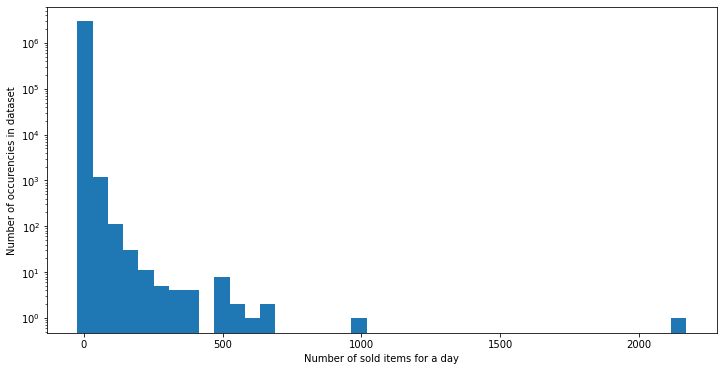

In [7]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

Group number of sold items by date_block and plot.

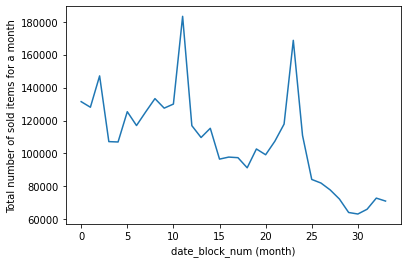

In [8]:
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

There is an obvious trend with peaks at New Year holidays.

# item_price

Distribution of items price and outliers

In [9]:
sales_train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

<AxesSubplot:xlabel='item_price'>

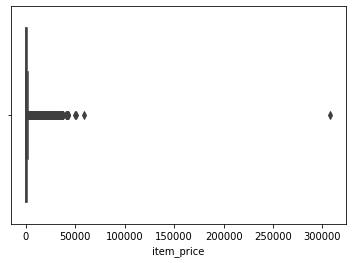

In [10]:
sns.boxplot(x='item_price', data=sales_train)

Majority of items has price lower than 5000.

# date_block_num

In [11]:
sales_train.date_block_num.describe()

count    2.935849e+06
mean     1.456991e+01
std      9.422988e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

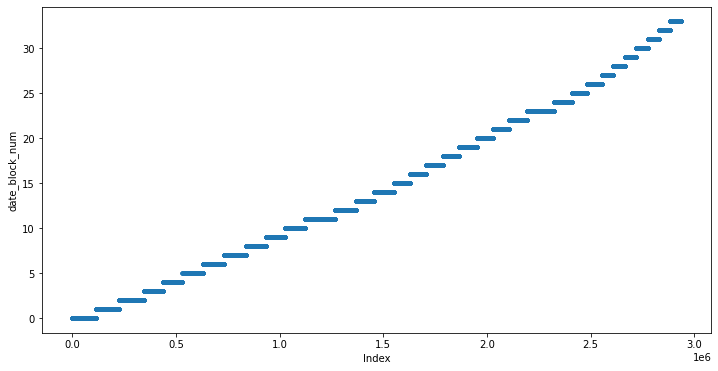

In [12]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

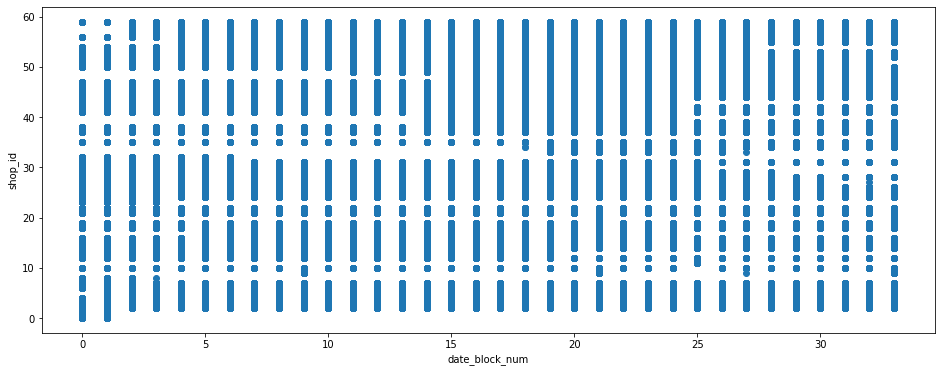

In [13]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

# shop_id

What shops are presented in train set but aren't presented in the test set?

<AxesSubplot:>

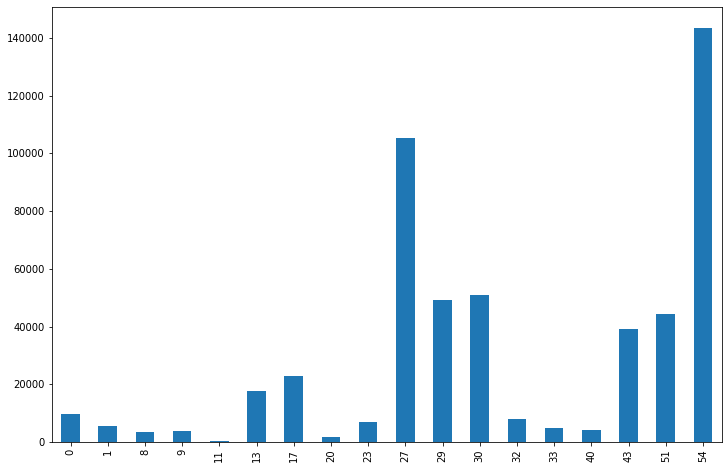

In [14]:
missed_ind = sorted([c for c in sales_train.shop_id.unique() if c not in sales_test.shop_id.unique()])
sales_train.shop_id.value_counts().sort_index().iloc[missed_ind].plot.bar(figsize=(12, 8))

Me may don't need shops with id's 8, 9, 11, 20 and 40. 

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix wrong shops id's

Some shop names look similar

In [15]:
print(shops.loc[shops.shop_id.isin([0, 57]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([1, 58]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([39, 40]), 'shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


Let's correct this

In [16]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39
sales_test.loc[sales_test.shop_id == 40, 'shop_id'] = 39

# Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference for each item and find the most frequent normal prices for them.

In [17]:
# for each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
1837          0.50  2599.0  1999.0   5198.000000

Fix wrong prices

In [18]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
# shops_last_prices = sales_train[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', 
#                                                                                'item_id']).agg('last')

# sales_test = sales_test.join(shops_last_prices, on=['shop_id', 'item_id'])
# sales_test.drop('ID', axis=1, inplace=True)

Group dataset by shop, item and date number.

# Group train dataset, investigate data distribution for train and test datasets.

In [19]:
#drop date feature, it's erratic
sales_train.drop('date', axis=1, inplace=True)

sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

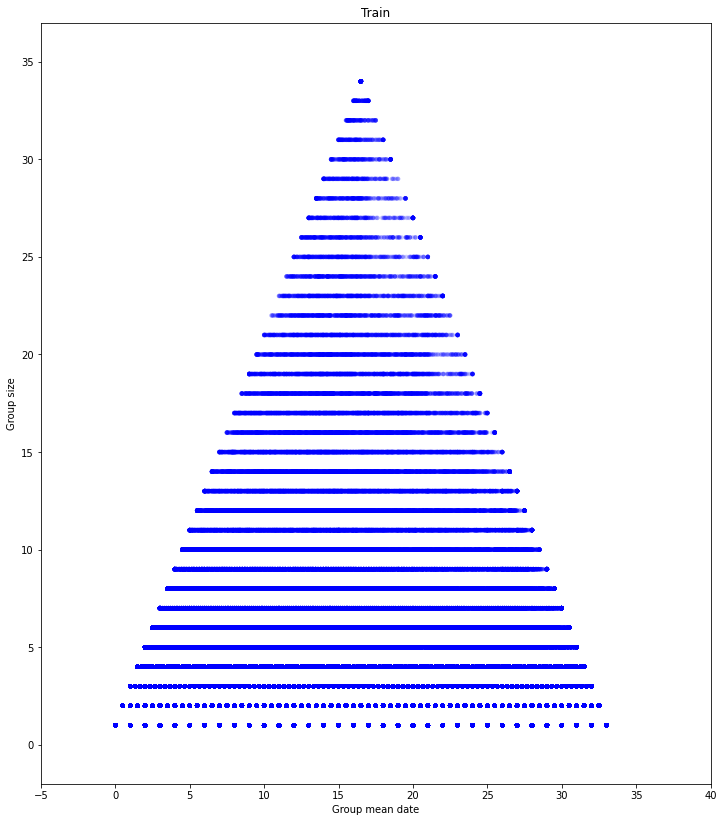

In [20]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.xlim(-5, 40)
plt.title('Train');

Test dataset

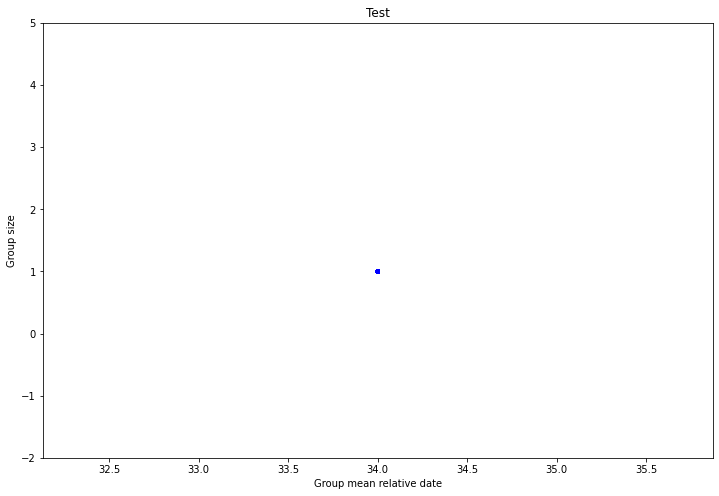

In [21]:
sales_test['date_block_num'] = 34
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For groups in the top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_day feature in our dataset. 

In [22]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629372
Name: item_cnt_day, dtype: int64

So, in the train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

We should also add to our dataset item ids that are presented in the test dataset but aren't presented in the train.

In [23]:
# # find all items, that are presented in the test dataset, but aren't presented in the train dataset
# sales_test1 = sales_test.loc[~sales_test.item_id.isin(sales_train.item_id.unique())].copy()
# sales_test1.loc[:, 'item_cnt_day'] = 0

# # for each 
# for i in range(1, 34):
#     # add these items to the train dataset
#     sales_train = pd.concat([sales_train, sales_test1])
#     # set date_block_num values that equal to 34, to 33, fill NaN item_cnt_day values with zeros
#     sales_train.loc[sales_train.date_block_num == 34, 'date_block_num'] = i
# sales_train.item_cnt_day.fillna(0, inplace=True)

# Create all unique combinations of shop_id, item_id and date_block_num

In [24]:
%%time

from itertools import product

index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})

#join aggregated data to the grid
sales_train2 = pd.merge(grid, gb, how='left', on=index_cols)

#sort the data
sales_train2.sort_values(['date_block_num', 'shop_id', 'item_id'],inplace=True)

# rename target column name
sales_train2.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

# reset index for new train dataset
sales_train2.reset_index(inplace=True)

# drop index column
sales_train2.drop('index', axis=1, inplace=True)

# flll NaN item_cnt_month values
sales_train2.item_cnt_month.fillna(0, inplace=True)

sales_test2 = sales_test.copy()

# uncomment if need to fill prices
# # fill NaN item prices, if possible
# sales_prices = sales_train2.dropna().groupby(['date_block_num', 'item_id']).agg({'item_price': lambda x: x.iloc[-1]})
# sales_train2 = sales_train2.join(sales_prices, on=['date_block_num', 'item_id'], rsuffix='_r')
# sales_train2.loc[(sales_train2.item_price.isnull()) & (~sales_train2.item_price_r.isnull()), 
#                  'item_price'] = sales_train2.item_price_r
# sales_train2.drop('item_price_r', axis=1, inplace=True)

CPU times: user 9.7 s, sys: 995 ms, total: 10.7 s
Wall time: 10.2 s


Distribution of items for each shop

<AxesSubplot:xlabel='shop_id'>

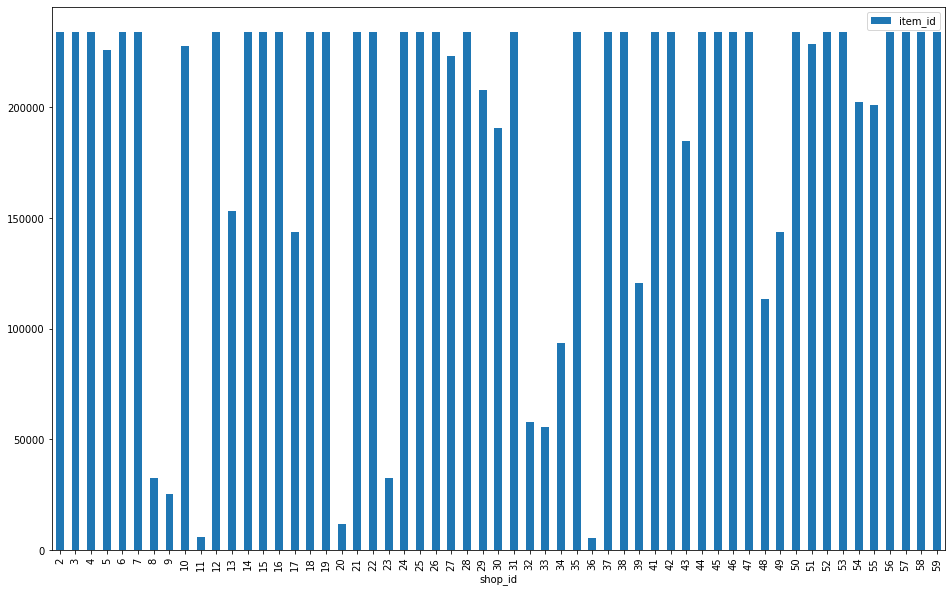

In [25]:
sales_train2.groupby('shop_id').agg({'item_id': 'count'}).plot.bar(figsize=(16, 10))

# Add calendar features

In [26]:
import math
import calendar
import holidays
import datetime

date_blocks = pd.DataFrame(sales_train2.date_block_num.drop_duplicates())
date_blocks = date_blocks.append({'date_block_num': 34}, ignore_index=True)

def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_year_month(row):
    return f'{row.year}-{row.month}'

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

# get number of holidays + weekend in each month    
ru_holidays = []

for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
    ru_holidays.append(date)
    
def add_holidays_and_weekends(row):
    busines_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
    busines_dates = [b for b in busines_dates if b not in ru_holidays]
    return row.days_in_month - len(busines_dates)
    
def add_weeks_in_month(row):
    for i in range(1, row.days_in_month+1):
        d = datetime.datetime(row.year, row.month, i)
        if d.day > d.weekday():
            startdate = d
            break
    return ((datetime.datetime(row.year, row.month, row.days_in_month) - startdate).days) //7 + 1 
    
def create_calendar_features(data):
    data['month'] = data.date_block_num.apply(add_month) 
    data['year'] = data.date_block_num.apply(add_year)
    data['year_month'] = data.apply(add_year_month, axis=1)
    data.year_month = pd.to_datetime(data.year_month, format='%Y-%m')
    data['days_in_month'] = data.year_month.dt.daysinmonth
    data['weeks_in_month'] = data.apply(add_weeks_in_month, axis=1)
    data['season'] = data.month.apply(add_season)
    data['holidays_and_weekends_in_month'] = data.apply(add_holidays_and_weekends, axis=1)
    data.drop('year_month', axis=1, inplace=True)


create_calendar_features(date_blocks)
date_blocks.head()

,date_block_num,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,0,1,2013,31,4,winter,14
1,1,2,2013,28,4,winter,8
2,2,3,2013,31,4,spring,11
3,3,4,2013,30,5,spring,8
4,4,5,2013,31,4,spring,10


# Add expert features for items and shops

In [27]:
def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Цифровой':
        return 'Цифровой склад'
    if city[0] == 'Выездная':
        return 'Выездная Торговля'
    return city[0]

def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

def add_platform(col):
    platform_list = ['PS', 'XBOX', 'PC', 'Android', 'MAC', 'Windows', '1С', 'Blu-Ray',
                    'CD', 'DVD', 'MP3']
    for platform in platform_list:
        if platform in col:
            return platform
    return 'None'

def add_digital(col):
    if 'Цифра' in col:
        return 1
    return 0


shops['city'] = shops.shop_name.apply(add_city)

item_categories['global_category'] = item_categories.item_category_name.apply(add_global_category)
item_categories['platform'] = item_categories.item_category_name.apply(add_platform)
item_categories['is_digital'] = item_categories.item_category_name.apply(add_digital)

shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [28]:
item_categories.head()

,item_category_name,item_category_id,global_category,platform,is_digital
0,PC - Гарнитуры/Наушники,0,PC,PC,0
1,Аксессуары - PS2,1,Аксессуары,PS,0
2,Аксессуары - PS3,2,Аксессуары,PS,0
3,Аксессуары - PS4,3,Аксессуары,PS,0
4,Аксессуары - PSP,4,Аксессуары,PS,0


# Add data from other datasets to train and test datasets

Train dataset

In [29]:
sales_train2 = sales_train2.join(items.set_index('item_id'), on='item_id')
sales_train2 = sales_train2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_train2 = sales_train2.join(shops.set_index('shop_id'), on='shop_id')
sales_train2 = sales_train2.join(date_blocks.set_index('date_block_num'), on='date_block_num')

sales_train2.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_category_name,global_category,platform,is_digital,shop_name,city,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,2,19,0,0.0,NaN,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,Кино,DVD,0,"Адыгея ТЦ ""Мега""",Адыгея,1,2013,31,4,winter,14
1,2,27,0,1.0,2499.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,Игры,PS,0,"Адыгея ТЦ ""Мега""",Адыгея,1,2013,31,4,winter,14
2,2,28,0,0.0,NaN,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,Игры,PC,0,"Адыгея ТЦ ""Мега""",Адыгея,1,2013,31,4,winter,14
3,2,29,0,0.0,NaN,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,Игры,XBOX,0,"Адыгея ТЦ ""Мега""",Адыгея,1,2013,31,4,winter,14
4,2,32,0,0.0,NaN,1+1,40,Кино - DVD,Кино,DVD,0,"Адыгея ТЦ ""Мега""",Адыгея,1,2013,31,4,winter,14


Test dataset

In [30]:
sales_test2 = sales_test.join(items.set_index('item_id'), on='item_id')
sales_test2 = sales_test2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_test2 = sales_test2.join(shops.set_index('shop_id'), on='shop_id')
sales_test2['date_block_num'] = 34
sales_test2.drop('ID', axis=1, inplace=True)
sales_test2 = sales_test2.join(date_blocks.set_index('date_block_num'), on='date_block_num')

sales_test2.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_category_name,global_category,platform,is_digital,shop_name,city,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS,0,"Вологда ТРЦ ""Мармелад""",Вологда,11,2015,30,5,autumn,10
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,Музыка,CD,0,"Вологда ТРЦ ""Мармелад""",Вологда,11,2015,30,5,autumn,10
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,Игры,PS,0,"Вологда ТРЦ ""Мармелад""",Вологда,11,2015,30,5,autumn,10
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,Игры,XBOX,0,"Вологда ТРЦ ""Мармелад""",Вологда,11,2015,30,5,autumn,10
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,Игры - PS4,Игры,PS,0,"Вологда ТРЦ ""Мармелад""",Вологда,11,2015,30,5,autumn,10


# Create mean encoded features

In [31]:
%%time

def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'city', 'item_id', 'global_category']:
        # create_col_with_min_freq(data, cat_col, 15,)
        for num_col in ['item_cnt_month', 'item_price']:
            for n, f in [('mean', np.mean)]:
                data[n + '_' + num_col + 
                     '_by_' + cat_col] = sales_train2.groupby(['date_block_num', 
                                                               cat_col])[num_col].transform(f)
                
create_gr_feats(sales_train2)
create_gr_feats(sales_test2)

CPU times: user 8.37 s, sys: 1.6 s, total: 9.97 s
Wall time: 9.97 s


# Add item_price features

In [32]:
# %%time

# def add_int_part(col):
#     if np.isnan(col):
#         return np.nan
#     return divmod(col, 100)[0]

# def add_fract_part(col):
#     if np.isnan(col):
#         return np.nan
#     return divmod(col, 100)[1]

# def create_price_features(data):
#     data['price_int'] = data.item_price.apply(add_int_part) 
#     data['price_fract'] = data.item_price.apply(add_fract_part) 

# create_price_features(sales_train2)
# create_price_features(sales_test2)   

# sales_train2.head()

# Add mean encoded features from previous months

In [33]:
%%time

mean_cols = [c for c in sales_train2.columns if c.startswith('mean_item_cnt', 0, 13)] + ['item_cnt_month']

def create_time_features():
    global sales_train2, sales_test2
    win = [i for i in range(1, 4)]
    for w in win:
        tmp = sales_train2[['date_block_num', 'shop_id', 'item_id'] + mean_cols].copy()
        tmp.date_block_num = tmp.date_block_num + w
        for c in mean_cols:
            tmp.rename({c: c + str(w)}, axis=1, inplace=True)

        sales_train2 = sales_train2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                         on=['date_block_num', 'shop_id', 'item_id'])
        sales_test2 = sales_test2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                       on=['date_block_num', 'shop_id', 'item_id'])
        del tmp
        gc.collect()

# drop all mean encoded columns, except item_cnt_month
create_time_features()
mean_cols.remove('item_cnt_month')
sales_train2.drop(mean_cols, axis=1, inplace=True)
sales_test2.drop(mean_cols, axis=1, inplace=True)

CPU times: user 21.9 s, sys: 7.89 s, total: 29.8 s
Wall time: 29.3 s


# Add time statistics (mean, mode, min, max, std)

In [34]:
def create_time_statistics(data):
    for win in [3]:
        cols = get_window(data, win)
        tmp = data[cols]
        
        data[f'{win}_month_mean_cnt'] = tmp.mean(axis=1)
        data[f'{win}_month_median_cnt'] = tmp.median(axis=1)
        data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1)
        data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1)
        data[f'{win}_month_std_cnt'] = tmp.std(axis=1)
        
            
def get_window(data, w):
    cols = []
    col_num = 1
    for i in data.columns:
        if col_num > w:
            break
        if i == f'item_cnt_month{col_num}':
            cols.append(i)
            col_num += 1
    return cols

create_time_statistics(sales_train2)
create_time_statistics(sales_test2)

<ipython-input-34-ce84fc59dcf4>:8: RuntimeWarning: All-NaN axis encountered
  data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1)
<ipython-input-34-ce84fc59dcf4>:9: RuntimeWarning: All-NaN axis encountered
  data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1)
<ipython-input-34-ce84fc59dcf4>:8: RuntimeWarning: All-NaN axis encountered
  data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1)
<ipython-input-34-ce84fc59dcf4>:9: RuntimeWarning: All-NaN axis encountered
  data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1)


# Drop unnecessary columns and rows

In [35]:
sales_train2.drop(['shop_name', 'item_name', 'item_price', 'item_category_name'], axis=1, inplace=True)
sales_test2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

# drop rows from first 3 months
sales_train2 = sales_train2[sales_train2.date_block_num > 2]

# Encode text features with label encoder.

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cols = ['city', 'platform', 'season', 'global_category']
sales_train2[cols] = sales_train2[cols].apply(LabelEncoder().fit_transform)
sales_test2[cols] = sales_test2[cols].apply(LabelEncoder().fit_transform)

Save data to files

In [37]:
# sales_train2.to_hdf('sales_train2', key='df')
# sales_test2.to_hdf('sales_test2', key='df')

In [38]:
sales_train2.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,global_category,platform,is_digital,city,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month,mean_item_price_by_shop_id,mean_item_price_by_item_category_id,mean_item_price_by_city,mean_item_price_by_item_id,mean_item_price_by_global_category,mean_item_cnt_month_by_shop_id1,mean_item_cnt_month_by_item_category_id1,mean_item_cnt_month_by_city1,mean_item_cnt_month_by_item_id1,mean_item_cnt_month_by_global_category1,item_cnt_month1,mean_item_cnt_month_by_shop_id2,mean_item_cnt_month_by_item_category_id2,mean_item_cnt_month_by_city2,mean_item_cnt_month_by_item_id2,mean_item_cnt_month_by_global_category2,item_cnt_month2,mean_item_cnt_month_by_shop_id3,mean_item_cnt_month_by_item_category_id3,mean_item_cnt_month_by_city3,mean_item_cnt_month_by_item_id3,mean_item_cnt_month_by_global_category3,item_cnt_month3,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt
1122795,2,27,3,0.0,19,5,9,0,0,4,2013,30,5,1,8,1130.086638,1387.412918,1130.086638,1998.000000,879.413970,0.090701,1.145206,0.090701,0.086957,1.258252,0.0,0.059745,0.918228,0.059745,0.065217,0.956883,0.0,0.14122,0.849456,0.14122,0.155556,0.955309,1.0,0.333333,0.0,0.0,1.0,0.577350
1122796,2,28,3,0.0,30,5,8,0,0,4,2013,30,5,1,8,1130.086638,377.418002,1130.086638,389.500000,879.413970,0.090701,1.606379,0.090701,0.152174,1.258252,0.0,0.059745,1.087787,0.059745,0.173913,0.956883,0.0,0.14122,1.189612,0.14122,0.177778,0.955309,0.0,0.000000,0.0,0.0,0.0,0.000000
1122797,2,30,3,0.0,40,7,4,0,0,4,2013,30,5,1,8,1130.086638,221.597813,1130.086638,390.646390,334.495103,0.090701,0.310484,0.090701,11.043478,0.281779,1.0,0.059745,0.287635,0.059745,18.717391,0.264175,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.5,0.0,1.0,0.707107
1122798,2,31,3,1.0,37,7,2,0,0,4,2013,30,5,1,8,1130.086638,460.907204,1130.086638,681.323333,334.495103,0.090701,0.199019,0.090701,4.760870,0.281779,1.0,0.059745,0.199867,0.059745,13.652174,0.264175,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,2.5,1.0,4.0,2.121320
1122799,2,32,3,0.0,40,7,4,0,0,4,2013,30,5,1,8,1130.086638,221.597813,1130.086638,341.685714,334.495103,0.090701,0.310484,0.090701,3.869565,0.281779,0.0,0.059745,0.287635,0.059745,4.521739,0.264175,0.0,0.14122,0.310860,0.14122,6.644444,0.284659,0.0,0.000000,0.0,0.0,0.0,0.000000


In [39]:
sales_test2.head()

,ID,shop_id,item_id,date_block_num,item_category_id,global_category,platform,is_digital,city,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month,mean_item_price_by_shop_id,mean_item_price_by_item_category_id,mean_item_price_by_city,mean_item_price_by_item_id,mean_item_price_by_global_category,mean_item_cnt_month_by_shop_id1,mean_item_cnt_month_by_item_category_id1,mean_item_cnt_month_by_city1,mean_item_cnt_month_by_item_id1,mean_item_cnt_month_by_global_category1,item_cnt_month1,mean_item_cnt_month_by_shop_id2,mean_item_cnt_month_by_item_category_id2,mean_item_cnt_month_by_city2,mean_item_cnt_month_by_item_id2,mean_item_cnt_month_by_global_category2,item_cnt_month2,mean_item_cnt_month_by_shop_id3,mean_item_cnt_month_by_item_category_id3,mean_item_cnt_month_by_city3,mean_item_cnt_month_by_item_id3,mean_item_cnt_month_by_global_category3,item_cnt_month3,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt
0,0,5,5037,34,19,4,9,0,3,11,2015,30,5,0,10,893.468728,213.911584,893.468728,28.000000,333.394119,0.194347,0.380293,0.194347,0.568182,0.458975,0.0,0.214749,0.585664,0.214749,2.558140,0.531278,1.0,0.253328,0.673449,0.253328,2.833333,0.521601,3.0,1.333333,1.0,0.0,3.0,1.527525
1,1,5,5320,34,55,8,3,0,3,11,2015,30,5,0,10,893.468728,1474.824429,893.468728,2325.000000,899.974232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,19,4,9,0,3,11,2015,30,5,0,10,893.468728,369.563189,893.468728,549.000000,899.974232,0.194347,0.380293,0.194347,0.954545,0.458975,1.0,0.214749,0.585664,0.214749,1.860465,0.531278,3.0,0.253328,0.673449,0.253328,3.571429,0.521601,1.0,1.666667,1.0,1.0,3.0,1.154701
3,3,5,5232,34,23,4,11,0,3,11,2015,30,5,0,10,893.468728,1802.173092,893.468728,2346.750000,899.974232,0.194347,0.340600,0.194347,0.636364,0.458975,0.0,0.214749,0.587946,0.214749,1.116279,0.531278,0.0,0.253328,0.557082,0.253328,1.547619,0.521601,1.0,0.333333,0.0,0.0,1.0,0.577350
4,4,5,5268,34,20,4,9,0,3,11,2015,30,5,0,10,893.468728,213.911584,893.468728,335.042318,333.394119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clip train target value

In [40]:
sales_train2.item_cnt_month.clip(0, 20, inplace=True)

sales_train2.fillna(0, inplace=True)
sales_test2.fillna(0, inplace=True)

# Train model

Split datasets by train and validation parts

In [41]:
# sales_train2.to_hdf('sales_train2', key='df')
# sales_test2.to_hdf('sales_test2', key='df')

In [42]:
cols = [col for col in sales_train2.columns if col not in ['item_cnt_month']]

x = sales_train2[cols]
y = sales_train2['item_cnt_month']

train_index = x[(x.date_block_num < 33)].index
valid_index = x[x.date_block_num == 33].index

X_train, X_valid = x.loc[train_index], x.loc[valid_index]

del x
gc.collect()

y_train, y_valid = y.loc[train_index], y.loc[valid_index]

Train LGBM

In [43]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

mean_score = []

feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 32,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}
cat_feats = ['item_category_id', 
             'city', 
             'global_category', 
             'platform']

lgb_train = lgb.Dataset(X_train[feature_name], y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=500,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = cat_feats,
        verbose_eval=10, 
        evals_result = evals_result,
        early_stopping_rounds = 10)

/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city', 'global_category', 'item_category_id', 'platform']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 1.19244	valid_1's rmse: 1.11807
[20]	training's rmse: 1.1703	valid_1's rmse: 1.10089
[30]	training's rmse: 1.14977	valid_1's rmse: 1.08561
[40]	training's rmse: 1.13082	valid_1's rmse: 1.07171
[50]	training's rmse: 1.1131	valid_1's rmse: 1.05886
[60]	training's rmse: 1.09674	valid_1's rmse: 1.04726
[70]	training's rmse: 1.08168	valid_1's rmse: 1.03652
[80]	training's rmse: 1.06763	valid_1's rmse: 1.02712
[90]	training's rmse: 1.05459	valid_1's rmse: 1.01851
[100]	training's rmse: 1.04246	valid_1's rmse: 1.01093
[110]	training's rmse: 1.0311	valid_1's rmse: 1.00381
[120]	training's rmse: 1.02059	valid_1's rmse: 0.99743
[130]	training's rmse: 1.01096	valid_1's rmse: 0.991514
[140]	training's rmse: 1.00176	valid_1's rmse: 0.986312
[150]	training's rmse: 0.993358	valid_1's rmse: 0.981325
[160]	training's rmse: 0.985545	valid_1's rmse: 0.976847
[170]	training's rmse: 0.978328	valid_1's rmse: 0.973
[180]	train

Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

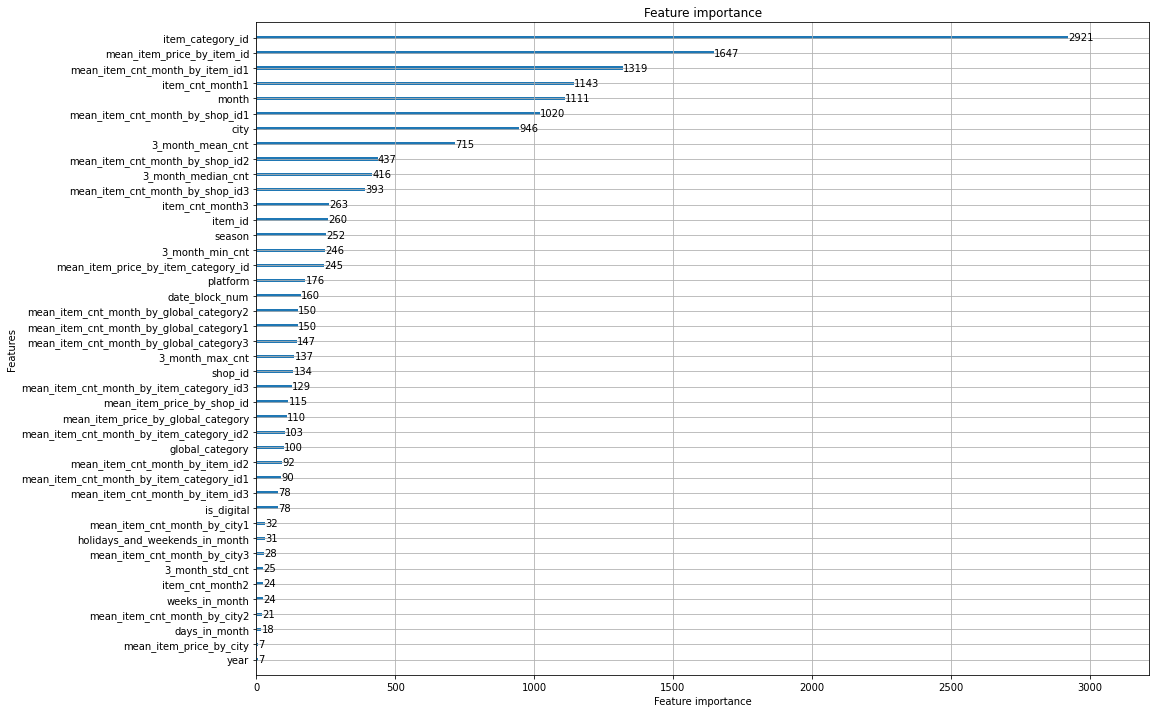

In [44]:
lgb.plot_importance(gbm, figsize=(16, 12))

Model learning curve

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

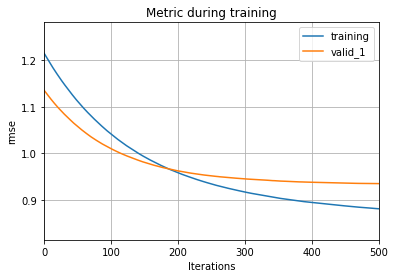

In [45]:
lgb.plot_metric(evals_result)

# Make prediction

In [54]:
y = gbm.predict(sales_test2)

null_ind = sales_test.loc[~sales_test.item_id.isin(sales_train.item_id.unique())].index

submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

,ID,item_cnt_month
0,0,0.498734
1,1,0.214278
2,2,0.784179
3,3,0.340736
4,4,1.743814
5,5,0.483901
6,6,1.070180
7,7,0.121380
8,8,0.628102
9,9,0.528372


# Save to file

In [55]:
submission.to_csv('submission.csv', index=False)

# Futher ideas

- do not use price fract

- are item_id, shop_id have to be categorical values?

- add coordinates of the each city

- delete shops with ids 9, 11 and 20

- try AutoML

- replace nan values with -1

- split dataset according to most important feature(s)
